# Generate Network Structure From .xlsx File

In [1]:
#import libraries 
import pandas as pd
import os 
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx 
import time as pytime 
import datetime as dt 

### Import and format raw data 

In [2]:
#read Excel File 
x = pd.read_excel('NationalOutbreakPublicDataTool.xlsx')

In [3]:
#make TWO new dataframes - one for norovirus (x_n) and one for salmonella (x_s)
norovirus = ['Norovirus Genogroup I', 'Norovirus Genogroup II','Norovirus unknown','Norovirus']
salmonella = ['Salmonella enterica']

#make norovirus dataframe
x_n = pd.DataFrame()
for i in norovirus:
    x_sub = x[x.Etiology == i]
    if i == 'Norovirus Genogroup I':
        x_n = x_sub
    else: x_n = pd.concat([x_n, x_sub])

#make salmonella dataframe
x_s = pd.DataFrame()
x_s = x[x.Etiology == salmonella[0]]

x_n = x_n.reset_index()
x_s = x_s.reset_index()
x_n.pop('index')
x_s.pop('index')


#drop any cases that are attributed to multistates
x_n = x_n[x_n.State != 'Multistate']
x_s = x_s[x_s.State != 'Multistate']

In [4]:
#print preview of norovirus file 
x_n

,Year,Month,State,Primary Mode,Etiology,Serotype or Genotype,Etiology Status,Setting,Illnesses,Hospitalizations,...,Deaths,Info on Deaths,Food Vehicle,Food Contaminated Ingredient,IFSAC Category,Water Exposure,Water Type,Animal Type,Animal Type Specify,Water Status
0,2009,1,Tennessee,Food,Norovirus Genogroup I,NaN,Confirmed,Grocery store,8,1.0,...,0.0,8.0,cake,NaN,Multiple,NaN,NaN,NaN,NaN,NaN
1,2009,3,Tennessee,Food,Norovirus Genogroup I,NaN,Confirmed,Restaurant - Sit-down dining,9,0.0,...,0.0,9.0,"oysters, raw",oysters,Mollusks,NaN,NaN,NaN,NaN,NaN
2,2009,1,Tennessee,Food,Norovirus Genogroup I,NaN,Confirmed,"Restaurant - ""Fast-food""(drive up service or p...",6,0.0,...,0.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2009,1,Florida,Food,Norovirus Genogroup I,NaN,Confirmed,Restaurant - other or unknown type,24,0.0,...,0.0,24.0,"sandwich, wrap; sandwich, wrap",NaN,Multiple,NaN,NaN,NaN,NaN,NaN
4,2009,2,Ohio,Food,Norovirus Genogroup I,NaN,Confirmed,Caterer (food prepared off-site from where ser...,70,1.0,...,0.0,70.0,egg salad/egg salad sandwich,NaN,Multiple,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6154,2018,11,Illinois,Food,Norovirus,NaN,Suspected,Caterer (food prepared off-site from where ser...,21,0.0,...,0.0,20.0,italian beef sandwich,NaN,Multiple,NaN,NaN,NaN,NaN,NaN
6155,2018,2,Georgia,Food,Norovirus,NaN,Suspected,Caterer (food prepared off-site from where ser...,17,0.0,...,0.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6156,2018,3,Washington,Food,Norovirus,NaN,Suspected,Restaurant - Sit-down dining,11,0.0,...,0.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6157,2018,11,Illinois,Food,Norovirus,NaN,Suspected,Restaurant - Sit-down dining,7,0.0,...,0.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Get list of neighboring states for every state 

In [5]:
#read excel spreadsheet with list of neighboring states 
ns = pd.read_excel('neighboring states.xlsx', header = None, index_col = 0)
neighbor_dict = {}
#each DF key maps to a string with states listed - e.g. 'Illinois, Indiana, Wisconsin'
#need to change this to a list - e.g. ['Illinois', 'Indiana', 'Wisconsin']
for i in ns.index:
    neighbor_dict[i] = list(ns.loc[i])[0].split(',')
    
#two small edits to make it work furter down 
neighbor_dict['Washington DC'] = ['Maryland', 'Virginia']
neighbor_dict['Puerto Rico'] = ['None']

#every state "borders" itself
for i in neighbor_dict:
    neighbor_dict[i].append(i)

### Generate network 

In [6]:
num_months = 3 
#check function - see if two year/month pairs occur within 3 months of each other 
def check(y1, m1, y2, m2): #input = year1, month1, year2, month2 
    #if two years are equal 
    if y1 == y2:
        #AND if the difference between the months is less than or equal to 3 
        if np.abs(m1 - m2) <= num_months:
            return True
    #if the difference between the two years is 1 
    elif np.abs(y1 - y2) == 1:
        #all possible ordered combinations of the two months 
        pairs = [(m1, m2), (m2, m1)]
        #all possible combinations of months in two consecutive years that could be 3 months apart 
        poss = [(12,1),(1,12), (2,12), (12, 2), (12,3), (3,12), (11,2), (2, 11), (11, 1), (1,11), (10, 1), (1, 10)]
        
        #check to see if the pair of months is in the given list 
        if pairs[0] in poss: 
            return True
        if pairs[1] in poss:
            return True
    #if none of these cases is True, return False 
    else: 
        return False 

In [7]:
#initialize graph
net = nx.Graph()

#add node for every case
for i in range(len(x_n)):
    net.add_node(i, state = x_n.iloc[i].State, etiology = x_n.iloc[i].Etiology, year = x_n.iloc[i].Year, month = x_n.iloc[i].Month)

In [8]:
#initialize list to hold all geographic edges
edges = []

start_time = pytime.time()

counter1 = 0 #initialize row counter 
for i in x_n.State: #iterate over EVERY ROW 
    counter2 = 0 #initialize second row counter
    year1 = x_n.iloc[counter1].Year
    month1 = x_n.iloc[counter2].Month
    
    for j in x_n.State: #iterate over EVERY ROW for EVERY ROW 
        if counter1 != counter2: #if they are not the same case 
            if i in neighbor_dict[j]: #AND if the states is neighboring
                year2 = x_n.iloc[counter2].Year
                month2 = x_n.iloc[counter2].Month
                if check(year1, month1,year2, month2) == True: #use check function to see if they are close enough in time
                    edges.append((counter1, counter2)) #ADD EDGE
        counter2 += 1 
    counter1 += 1
    
#log statements 
print('code block took ' + str(pytime.time() - start_time) + ' seconds to execute')
print('state edges = ' +str( len(edges) / len(x_n)**2) +' % of possible edge combinations')

code block took 1242.1789419651031 seconds to execute
state edges = 0.004353037501654269 % of possible edge combinations


In [9]:
print('state edges = ' +str( len(edges) / len(x_n)**2) +' % of possible edge combinations')
net.add_edges_from(edges)

state edges = 0.004353037501654269 % of possible edge combinations


### Network analytics

In [10]:
degrees = [net.degree(node) for node in net]
print('Average degree: ', str(np.mean(degrees)))
print("Number of nodes: ", len(net))
print("Number of edges: ", net.number_of_edges())
print("Number of connected components: ", nx.number_connected_components(net))

Average degree:  46.31491712707182
Number of nodes:  6154
Number of edges:  142511
Number of connected components:  96


### Save network to gexf 

In [11]:
nx.write_gexf(net, 'norovirus.gexf')

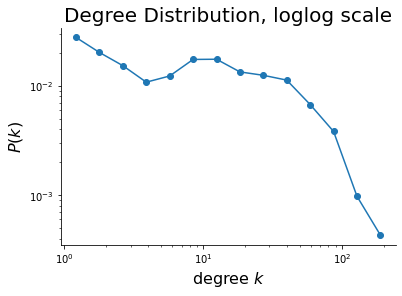

In [12]:
kmin = min(degrees) + 1
kmax = max(degrees)
# Get 10 logarithmically spaced bins between kmin and kmax
bin_edges = np.logspace(np.log10(kmin), np.log10(kmax), num=15)

# histogram the data into these bins
density, _ = np.histogram(degrees, bins=bin_edges, density=True)

# `_` indicates that `np.histogram()` is returning a tuple of two items, and we don't care about
# what's in the second element. what is the other thing it's returning? check the docs:
# https://numpy.org/doc/stable/reference/generated/numpy.histogram.html

fig = plt.figure(figsize=(6,4))

# "x" should be midpoint (IN LOG SPACE) of each bin
log_be = np.log10(bin_edges)
x = 10**((log_be[1:] + log_be[:-1])/2)

plt.loglog(x, density, marker='o')
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$P(k)$", fontsize=16)

# remove right and top boundaries because they're ugly
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.title('Degree Distribution, loglog scale', fontsize = 20)
# Show the plot
plt.show()

fig.savefig('degdist.png')

In [13]:
connect = nx.connect_components(net)

AttributeError: module 'networkx' has no attribute 'connect_components'